<h1>Morphology</h1>

In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
from tqdm import tqdm
import tifffile
import dask.dataframe as dd
import gzip
import shutil
import h5py

In [2]:
#micron to absolute pixel pos conversion factor (0.2125 micron is pixel size)
CONVERSION_FACTOR = 1/0.2125
CONVERSION_FACTOR

4.705882352941177

In [3]:
torch.cuda.is_available()

True

In [4]:
he_path = r"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/open_source_temp_data/Xenium_V1_FFPE_Human_Breast_IDC_With_Addon_he_image.ome.tif"

In [5]:
#import h&e tiff
import tifffile
he_load = tifffile.imread(he_path, is_ome = True, level = 0, aszarr = False)

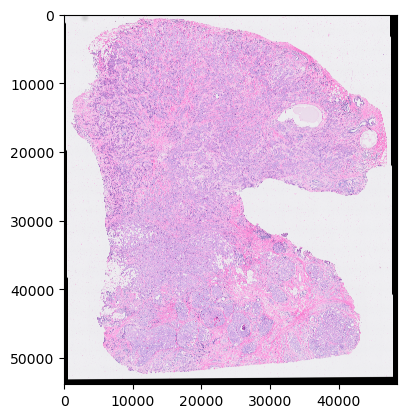

In [6]:
plt.imshow(np.asarray(he_load).transpose(1, 2, 0))

In [7]:
#store as PIL img
he_img = Image.fromarray(he_load.transpose(1,2,0))

In [11]:
boundaries_df = pd.read_parquet(r'/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/open_source_temp_data/cell_boundaries.parquet')
boundaries_df.head()

cell_id    vertex_x    vertex_y
0  b'aaaabecc-1'  848.512512  847.025024
1  b'aaaabecc-1'  843.200012  848.087524
2  b'aaaabecc-1'  843.412476  860.625000
3  b'aaaabecc-1'  841.287476  867.424988
4  b'aaaabecc-1'  841.287476  874.437500

In [12]:
#funcs to calc height and width of a cell
def calc_height(group):
    return CONVERSION_FACTOR*(group['vertex_y'].max() - group['vertex_y'].min())
def calc_width(group):
    return CONVERSION_FACTOR*(group['vertex_x'].max() - group['vertex_x'].min())
# def calc_x_center_points(group):
#     return CONVERSION_FACTOR*(group['vertex_x'].max()+group['vertex_x'].min())/2
# def calc_y_center_points(group):
#     return CONVERSION_FACTOR*(group['vertex_y'].max()+group['vertex_y'].min())/2

In [15]:
grouped = boundaries_df.groupby('cell_id')

all_heights = grouped.apply(calc_height)
max_height_px = all_heights.max()
print(max_height_px)

all_widths = grouped.apply(calc_width)
max_width_px = all_widths.max()
print(max_width_px)

# all_x_centers = grouped.apply(calc_x_center_points, meta=('x_center', 'f8')).compute()
# all_y_centers = grouped.apply(calc_y_center_points, meta=('y_center', 'f8')).compute()

237.0013786764706
238.00091911764707


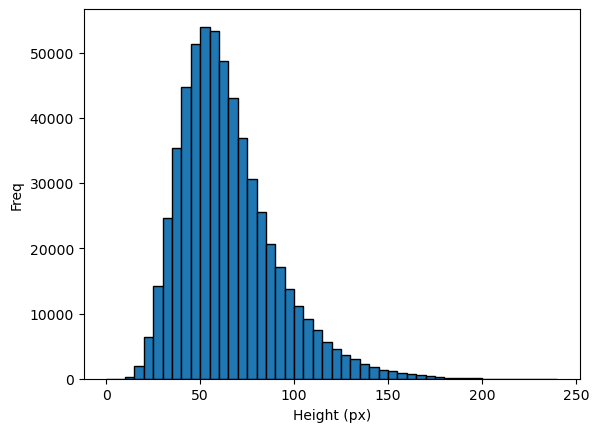

In [16]:
bins = range(0, int(max_height_px) + 5, 5)
plt.hist(all_heights, bins = bins, edgecolor='black')
plt.xlabel('Height (px)')
plt.ylabel('Freq')
plt.show()

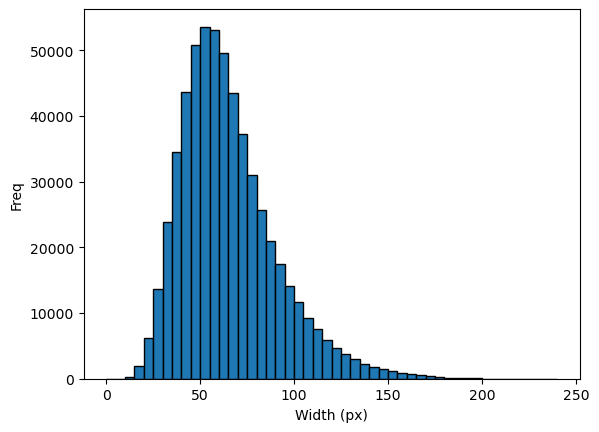

In [17]:
bins = range(0, int(max_width_px) + 5, 5)
plt.hist(all_widths, bins = bins, edgecolor='black')
plt.xlabel('Width (px)')
plt.ylabel('Freq')
plt.show()

In [18]:
all_widths_np = np.array(all_widths)
width_outlier_cutoff = np.percentile(all_widths_np,75) + 1.5 * (np.percentile(all_widths_np,75) - np.percentile(all_widths_np,25))
mean_width = np.mean(all_widths_np)

all_heights_np = np.array(all_heights)
height_outlier_cutoff = np.percentile(all_heights_np,75) + 1.5 * (np.percentile(all_heights_np,75) - np.percentile(all_heights_np,25))
mean_height = np.mean(all_heights_np)

print(width_outlier_cutoff)
print(height_outlier_cutoff)
print(mean_width)
print(mean_height)

124.50080422794116
123.50241268382354
64.56022071927072
64.18296821515385


In [21]:
import gzip
import shutil

gz_path = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/open_source_temp_data/cells.csv.gz"
dest_path = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/open_source_temp_data/cells.csv"
with gzip.open(gz_path, 'rb') as f_in:
    with open(dest_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
cell_df_csv = pd.read_csv(dest_path)
cell_df_csv.head()

cell_id   x_centroid   y_centroid  transcript_counts  \
0  aaaabecc-1   847.939590   860.676932                 57   
1  aaaabggh-1   831.635559   865.314319                 88   
2  aaaacpcd-1  1655.837872  8794.647021                190   
3  aaaaeclm-1  1645.499042  8798.733496                146   
4  aaaaiale-1  1653.466339  8805.801611                203   

   control_probe_counts  control_codeword_counts  unassigned_codeword_counts  \
0                     0                        0                           0   
1                     0                        0                           0   
2                     0                        0                           0   
3                     0                        0                           0   
4                     0                        0                           0   

   total_counts   cell_area  nucleus_area  
0            57  277.936719     29.216094  
1            88  687.955469     37.840938  
2           190  223.342813     29.216094  
3           146   96.995625     21.900781  
4           203  115.012969     44.162813

In [22]:
# width_px = int(mean_width)
# height_px = int(mean_height)

width_px = int(mean_width)
height_px = int(mean_height)

# width_px = int(width_outlier_cutoff)
# height_px = int(height_outlier_cutoff)

In [23]:
cells_arr = np.zeros((len(cell_df_csv), width_px, height_px, 3), dtype=np.uint8)
cells_arr.shape

(576963, 64, 64, 3)

In [24]:
morphology_data = []

In [25]:
for i, row in tqdm(cell_df_csv.iterrows(), total=len(cell_df_csv)):
    crop_region = (int(CONVERSION_FACTOR * (row['x_centroid'])) - (width_px / 2),
                   int(CONVERSION_FACTOR * (row['y_centroid'])) - (height_px / 2),
                   int(CONVERSION_FACTOR * (row['x_centroid'])) + (width_px / 2),
                   int(CONVERSION_FACTOR * (row['y_centroid'])) + (height_px / 2))
    
    temp_cell = he_img.crop(crop_region)
    cells_arr[i] = np.array(temp_cell, dtype=np.uint8)

    morphology_data.append({'cell_id': row['cell_id'], 'arr_index': i})

100%|█████████████████████████████████████████████████████████████████████████████████████| 576963/576963 [00:33<00:00, 17061.13it/s]


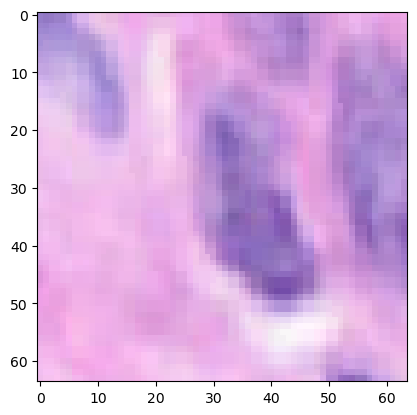

In [26]:
plt.imshow(cells_arr[1000])

In [27]:
morphology_df = pd.DataFrame(morphology_data)
morphology_df.to_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/poc/data/morphology_arr_indexes.csv", index=False)

In [28]:
morphology_df.head()

cell_id  arr_index
0  aaaabecc-1          0
1  aaaabggh-1          1
2  aaaacpcd-1          2
3  aaaaeclm-1          3
4  aaaaiale-1          4

In [29]:
import h5py
import numpy as np

with h5py.File('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/poc/data/meansize_cells.h5', 'w') as hf:
    hf.create_dataset('cells', data=cells_arr, compression='gzip', compression_opts=9)

In [ ]:
#SAVE UPPER OUTLIER BOUNDARY SIZE
# import h5py
# import numpy as np

# with h5py.File('uppersize_cells.h5', 'w') as hf:
#     hf.create_dataset('cells', data=cells_arr, compression='gzip', compression_opts=9)

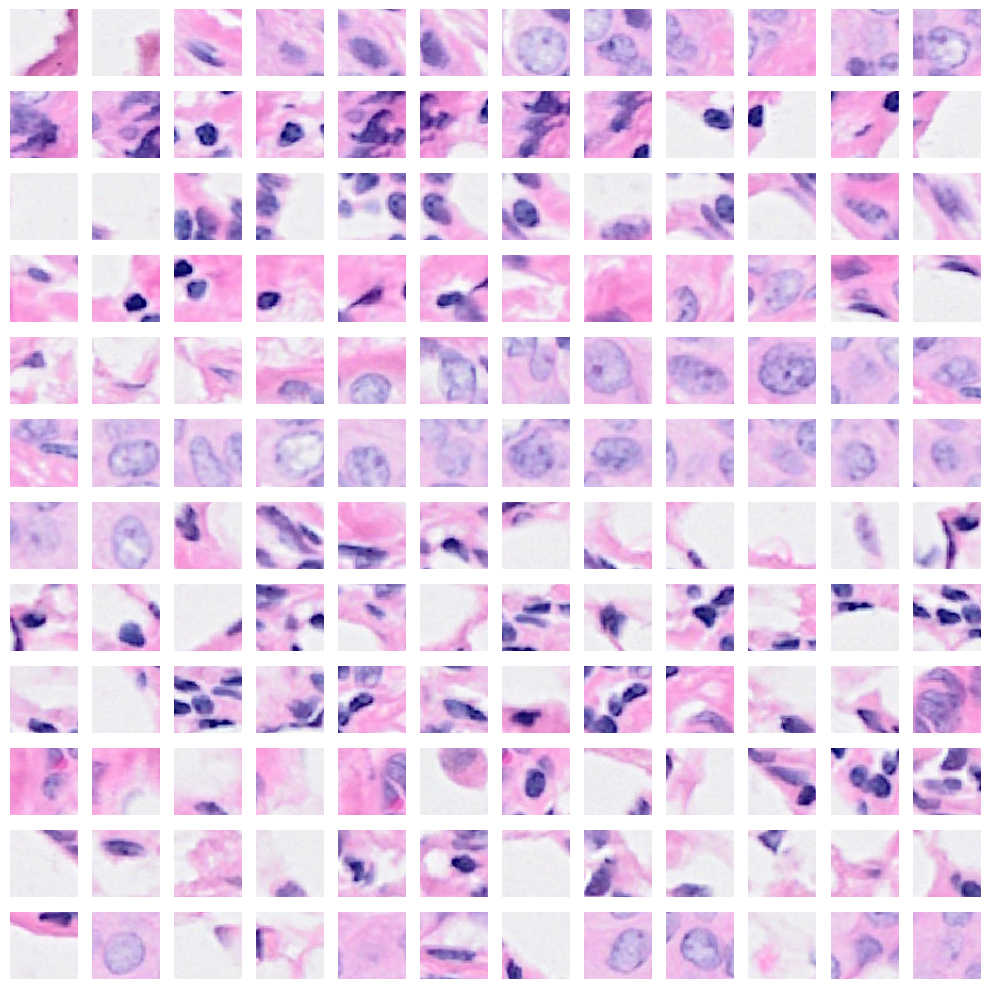

In [30]:
#provided centroid coordinates
grid_size = 12

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        cell_index = i * grid_size + j
#         crop_region = (cell_df_csv['x_centroid'][cell_index] - (max_width_px / 2), cell_df_csv['y_centroid'][cell_index] - (max_height_px / 2), cell_df_csv['x_centroid'][cell_index] + (max_width_px / 2), cell_df_csv['y_centroid'][cell_index] + (max_height_px / 2))
        crop_region = ((CONVERSION_FACTOR*(cell_df_csv['x_centroid'][cell_index])) - (width_px / 2), (CONVERSION_FACTOR*(cell_df_csv['y_centroid'][cell_index])) - (height_px / 2), (CONVERSION_FACTOR*(cell_df_csv['x_centroid'][cell_index])) + (width_px / 2), (CONVERSION_FACTOR*(cell_df_csv['y_centroid'][cell_index])) + (height_px / 2))
        sample_cell = he_img.crop(crop_region)
        axes[i, j].imshow(sample_cell)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

<h1>Expression Vectors</h1>

In [8]:
import scanpy as sc

In [9]:
import NaiveDE
import SpatialDE

In [10]:
adata = sc.read_10x_h5(r"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/open_source_temp_data/cell_feature_matrix.h5")

In [11]:
df_counts = adata.to_df()
df_counts = df_counts.sort_index()
df_counts.head()

ABCC11  ACKR1  ACTA2  ACTG2  ADAM9  ADGRE5  ADGRL4  ADH1B  ADIPOQ  \
aaaabecc-1     0.0    0.0    0.0    0.0    0.0     0.0     0.0    0.0     0.0   
aaaabggh-1     0.0    0.0    3.0    0.0    0.0     0.0     0.0    0.0     0.0   
aaaacpcd-1     0.0    0.0    2.0    0.0    2.0     1.0     1.0    0.0     0.0   
aaaaeclm-1     1.0    0.0    1.0    0.0    0.0     0.0     0.0    0.0     0.0   
aaaaiale-1     2.0    0.0    0.0    0.0    1.0     0.0     0.0    0.0     0.0   

            AEBP1  ...  UCP1  USP53  VEGFC  VOPP1  VWF  WARS  XCR1  ZEB1  \
aaaabecc-1    0.0  ...   0.0    0.0    0.0    0.0  0.0   0.0   0.0   0.0   
aaaabggh-1    0.0  ...   0.0    0.0    0.0    0.0  0.0   0.0   0.0   0.0   
aaaacpcd-1    4.0  ...   0.0    0.0    0.0    1.0  2.0   1.0   0.0   5.0   
aaaaeclm-1    0.0  ...   0.0    0.0    0.0    0.0  0.0   0.0   0.0   0.0   
aaaaiale-1    0.0  ...   0.0    1.0    0.0    1.0  0.0   1.0   0.0   0.0   

            ZEB2  ZNF562  
aaaabecc-1   0.0     0.0  
aaaabggh-1   0.0     0.0  
aaaacpcd-1   0.0     0.0  
aaaaeclm-1   0.0     0.0  
aaaaiale-1   0.0     2.0  

[5 rows x 380 columns]

In [7]:
df_coords = pd.read_csv(r'/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/open_source_temp_data/cells.csv')
df_coords = df_coords.sort_values(by = 'cell_id')[['cell_id', 'x_centroid', 'y_centroid']]
df_coords.head()

cell_id   x_centroid   y_centroid
0  aaaabecc-1   847.939590   860.676932
1  aaaabggh-1   831.635559   865.314319
2  aaaacpcd-1  1655.837872  8794.647021
3  aaaaeclm-1  1645.499042  8798.733496
4  aaaaiale-1  1653.466339  8805.801611

In [8]:
df = pd.DataFrame()

In [9]:
df['x'] = df_coords['x_centroid'].values * CONVERSION_FACTOR
df['y'] = df_coords['y_centroid'].values * CONVERSION_FACTOR

In [10]:
df_counts = df_counts.apply(pd.to_numeric)

In [11]:
df['total_counts'] = df_counts.sum(axis=1).values

In [12]:
df.head()

x             y  total_counts
0  3990.303955   4050.244385          57.0
1  3913.579102   4072.067383          88.0
2  7792.178223  41386.574219         190.0
3  7743.524902  41405.804688         146.0
4  7781.018066  41439.066406         203.0

In [13]:
df_counts['total_counts'] = df_counts.sum(axis=1).values

In [14]:
df_counts = df_counts[df_counts['total_counts'] != 0]

In [15]:
df = df[df['total_counts'] != 0]

In [16]:
len(df_counts)

576863

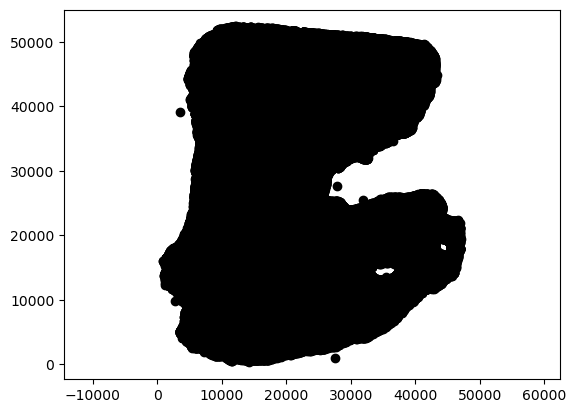

In [17]:
plt.scatter(df['x'], df['y'], c='k');
plt.axis('equal');

In [18]:
df_int = df.astype('uint8')

In [19]:
df_counts_int = df_counts.astype('uint8')

In [21]:
norm_expr = NaiveDE.stabilize(df_counts.T).T
resid_expr = NaiveDE.regress_out(df, norm_expr.T, 'np.log(total_counts)').T

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/AshankS/anaconda3/envs/Ashank/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [22]:
resid_expr = resid_expr.drop('total_counts', axis = 1)

In [23]:
X = df[['x', 'y']]
results = SpatialDE.run(X, resid_expr)

MemoryError: Unable to allocate 2.42 TiB for an array with shape (576863, 576863) and data type float64

In [4]:
# NEED TO NORMALIZE
sc.pp.normalize_total(adata, target_sum=1)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/AshankS/anaconda3/envs/Ashank/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [5]:
sc.pp.log1p(adata)

In [6]:
df_norm = adata.to_df()
df_norm.head()

ABCC11  ACKR1     ACTA2  ACTG2     ADAM9    ADGRE5    ADGRL4  \
aaaabecc-1  0.000000    0.0  0.000000    0.0  0.000000  0.000000  0.000000   
aaaabggh-1  0.000000    0.0  0.033523    0.0  0.000000  0.000000  0.000000   
aaaacpcd-1  0.000000    0.0  0.010471    0.0  0.010471  0.005249  0.005249   
aaaaeclm-1  0.006826    0.0  0.006826    0.0  0.000000  0.000000  0.000000   
aaaaiale-1  0.009804    0.0  0.000000    0.0  0.004914  0.000000  0.000000   

            ADH1B  ADIPOQ     AEBP1  ...  UCP1     USP53  VEGFC     VOPP1  \
aaaabecc-1    0.0     0.0  0.000000  ...   0.0  0.000000    0.0  0.000000   
aaaabggh-1    0.0     0.0  0.000000  ...   0.0  0.000000    0.0  0.000000   
aaaacpcd-1    0.0     0.0  0.020834  ...   0.0  0.000000    0.0  0.005249   
aaaaeclm-1    0.0     0.0  0.000000  ...   0.0  0.000000    0.0  0.000000   
aaaaiale-1    0.0     0.0  0.000000  ...   0.0  0.004914    0.0  0.004914   

                 VWF      WARS  XCR1      ZEB1  ZEB2    ZNF562  
aaaabecc-1  0.000000  0.000000   0.0  0.000000   0.0  0.000000  
aaaabggh-1  0.000000  0.000000   0.0  0.000000   0.0  0.000000  
aaaacpcd-1  0.010471  0.005249   0.0  0.025975   0.0  0.000000  
aaaaeclm-1  0.000000  0.000000   0.0  0.000000   0.0  0.000000  
aaaaiale-1  0.000000  0.004914   0.0  0.000000   0.0  0.009804  

[5 rows x 380 columns]

In [38]:
df_norm.to_parquet("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/poc/data/full_norm_gene_exp_vectors.parquet")

<h1>Compilation</h1>

In [39]:
data_path = r"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/poc/data/"
df_gene_exp = pd.read_parquet(data_path + "full_norm_gene_exp_vectors.parquet")
df_gene_exp = df_gene_exp.sort_values(by = 'index')
df_gene_exp.head()

ABCC11  ACKR1     ACTA2  ACTG2     ADAM9    ADGRE5    ADGRL4  \
index                                                                        
aaaabecc-1  0.000000    0.0  0.000000    0.0  0.000000  0.000000  0.000000   
aaaabggh-1  0.000000    0.0  0.033523    0.0  0.000000  0.000000  0.000000   
aaaacpcd-1  0.000000    0.0  0.010471    0.0  0.010471  0.005249  0.005249   
aaaaeclm-1  0.006826    0.0  0.006826    0.0  0.000000  0.000000  0.000000   
aaaaiale-1  0.009804    0.0  0.000000    0.0  0.004914  0.000000  0.000000   

            ADH1B  ADIPOQ     AEBP1  ...  UCP1     USP53  VEGFC     VOPP1  \
index                                ...                                    
aaaabecc-1    0.0     0.0  0.000000  ...   0.0  0.000000    0.0  0.000000   
aaaabggh-1    0.0     0.0  0.000000  ...   0.0  0.000000    0.0  0.000000   
aaaacpcd-1    0.0     0.0  0.020834  ...   0.0  0.000000    0.0  0.005249   
aaaaeclm-1    0.0     0.0  0.000000  ...   0.0  0.000000    0.0  0.000000   
aaaaiale-1    0.0     0.0  0.000000  ...   0.0  0.004914    0.0  0.004914   

                 VWF      WARS  XCR1      ZEB1  ZEB2    ZNF562  
index                                                           
aaaabecc-1  0.000000  0.000000   0.0  0.000000   0.0  0.000000  
aaaabggh-1  0.000000  0.000000   0.0  0.000000   0.0  0.000000  
aaaacpcd-1  0.010471  0.005249   0.0  0.025975   0.0  0.000000  
aaaaeclm-1  0.000000  0.000000   0.0  0.000000   0.0  0.000000  
aaaaiale-1  0.000000  0.004914   0.0  0.000000   0.0  0.009804  

[5 rows x 380 columns]

In [40]:
df_centroids = pd.read_csv(r'/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/open_source_temp_data/cells.csv')
df_centroids = df_centroids.sort_values(by = 'cell_id')
df_centroids.head()

cell_id   x_centroid   y_centroid  transcript_counts  \
0  aaaabecc-1   847.939590   860.676932                 57   
1  aaaabggh-1   831.635559   865.314319                 88   
2  aaaacpcd-1  1655.837872  8794.647021                190   
3  aaaaeclm-1  1645.499042  8798.733496                146   
4  aaaaiale-1  1653.466339  8805.801611                203   

   control_probe_counts  control_codeword_counts  unassigned_codeword_counts  \
0                     0                        0                           0   
1                     0                        0                           0   
2                     0                        0                           0   
3                     0                        0                           0   
4                     0                        0                           0   

   total_counts   cell_area  nucleus_area  
0            57  277.936719     29.216094  
1            88  687.955469     37.840938  
2           190  223.342813     29.216094  
3           146   96.995625     21.900781  
4           203  115.012969     44.162813

In [41]:
df_morph = pd.read_csv(data_path + "morphology_arr_indexes.csv")
df_morph = df_morph.sort_values(by = 'cell_id')
df_morph.head()

cell_id  arr_index
0  aaaabecc-1          0
1  aaaabggh-1          1
2  aaaacpcd-1          2
3  aaaaeclm-1          3
4  aaaaiale-1          4

In [42]:
df = pd.DataFrame(columns = ['cell_id', 'arr_index', 'x_centroid', 'y_centroid', 'gene_exp_vector'])
df.head()

Empty DataFrame
Columns: [cell_id, arr_index, x_centroid, y_centroid, gene_exp_vector]
Index: []

In [47]:
df['cell_id'] = df_morph['cell_id']
df['arr_index'] = df_morph['arr_index']
df['x_centroid'] = df_centroids['x_centroid'] * CONVERSION_FACTOR
df['y_centroid'] = df_centroids['y_centroid'] * CONVERSION_FACTOR

In [44]:
from tqdm import tqdm
for i, row in tqdm(df.iterrows(), total = len(df)):
    df.at[i, 'gene_exp_vector'] = df_gene_exp.iloc[i].tolist()

100%|█████████████████████████████████████████████████████████████████████████████████████| 576963/576963 [00:46<00:00, 12525.88it/s]


In [48]:
df.head()

cell_id  arr_index   x_centroid    y_centroid  \
0  aaaabecc-1          0  3990.303955   4050.244385   
1  aaaabggh-1          1  3913.579102   4072.067383   
2  aaaacpcd-1          2  7792.178223  41386.574219   
3  aaaaeclm-1          3  7743.524902  41405.804688   
4  aaaaiale-1          4  7781.018066  41439.066406   

                                     gene_exp_vector  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.03352269157767296, 0.0, 0.0, 0.0,...  
2  [0.0, 0.0, 0.010471300221979618, 0.0, 0.010471...  
3  [0.0068259648978710175, 0.0, 0.006825964897871...  
4  [0.00980400014668703, 0.0, 0.0, 0.0, 0.0049140...

In [49]:
df.to_parquet(data_path + "processed_df_full_exp.parquet")